In [1]:
import numpy as np
import gym
from gym.spaces import Discrete, Box
import torch.nn as nn
import torch
import torch.optim as optimizer
import torch.nn.functional as F
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import matplotlib
import torchvision.transforms as T
from torch.distributions import Categorical, Normal
from scipy import signal
import scipy
from torch import optim

In [2]:
# envfunv = lambda : gym.make('CartPole-v0')
env = gym.make('CartPole-v0')

In [3]:
# env2 = envfunv()
env.action_space
# env2.reset()
# env2.step(1)
# env.step(1)
# print(type(env), type(env2))

Discrete(2)

In [4]:
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = "cpu"

In [6]:
class Net(nn.Module):

    def __init__(self, h, w, outputs):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=5, stride=2)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=5, stride=2)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 32, kernel_size=5, stride=2)
        self.bn3 = nn.BatchNorm2d(32)

        # Number of Linear input connections depends on output of conv2d layers
        # and therefore the input image size, so compute it.
        def conv2d_size_out(size, kernel_size = 5, stride = 2):
            return (size - (kernel_size - 1) - 1) // stride  + 1
        convw = conv2d_size_out(conv2d_size_out(conv2d_size_out(w)))
        convh = conv2d_size_out(conv2d_size_out(conv2d_size_out(h)))
        linear_input_size = convw * convh * 32
        self.head = nn.Linear(linear_input_size, outputs)
        # self.out = F.softmax

    # Called with either one element to determine next action, or a batch
    # during optimization. Returns tensor([[left0exp,right0exp]...]).
    def forward(self, x):
        # print(x)
        x = x.to(device)
        # print('U', x[0])
        # print('O', np.shape(x))
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        return self.head(x.view(x.size(0), -1))

In [7]:
from torchvision.transforms import InterpolationMode
resize = T.Compose([T.ToPILImage(),
                    T.Resize(40, interpolation=InterpolationMode.BICUBIC),
                    T.ToTensor()])

In [8]:
def get_cart_location(screen_width):
    world_width = env.x_threshold * 2
    scale = screen_width / world_width
    return int(env.state[0] * scale + screen_width / 2.0)  # MIDDLE OF CART

In [9]:
import time
def get_screen():
    # Returned screen requested by gym is 400x600x3, but is sometimes larger
    # such as 800x1200x3. Transpose it into torch order (CHW).
    # time.sleep(2)
    screen = env.render(mode='rgb_array')
    screen  = screen.transpose((2, 0, 1))
    # screen = env.render(mode='rgb_array').transpose((2, 0, 1))
    # Cart is in the lower half, so strip off the top and bottom of the screen
    _, screen_height, screen_width = screen.shape
    screen = screen[:, int(screen_height*0.4):int(screen_height * 0.8)]
    view_width = int(screen_width * 0.6)
    cart_location = get_cart_location(screen_width)
    if cart_location < view_width // 2:
        slice_range = slice(view_width)
    elif cart_location > (screen_width - view_width // 2):
        slice_range = slice(-view_width, None)
    else:
        slice_range = slice(cart_location - view_width // 2,
                            cart_location + view_width // 2)
    # Strip off the edges, so that we have a square image centered on a cart
    screen = screen[:, :, slice_range]
    # Convert to float, rescale, convert to torch tensor
    # (this doesn't require a copy)
    screen = np.ascontiguousarray(screen, dtype=np.float32) / 255
    screen = torch.from_numpy(screen)
    # Resize, and add a batch dimension (BCHW)
    return resize(screen).unsqueeze(0)

In [10]:
env.render()

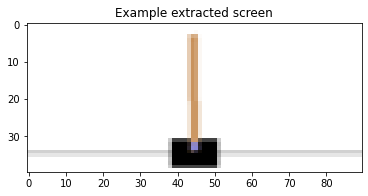

In [11]:
env.reset()
# print(env.render(mode="rgb_array"))
plt.figure()
plt.imshow(get_screen().cpu().squeeze(0).permute(1, 2, 0).numpy(),
           interpolation='none')
plt.title('Example extracted screen')
plt.show()

In [12]:
class Actor(nn.Module):
    
    def _distribution(self, obs):
        raise NotImplementedError

    def _log_prob_from_distribution(self, pi, act):
        raise NotImplementedError

    def forward(self, obs, act=None):
        # Produce action distributions for given observations, and 
        # optionally compute the log likelihood of given actions under
        # those distributions.
        pi = self._distribution(obs)
        logp_a = None
        if act is not None:
            logp_a = self._log_prob_from_distribution(pi, act)
        return pi, logp_a

In [13]:
class CategoricalActor(Actor):
    def __init__(self, h, w, act_dim = 1):
        super().__init__()
        self.logits_net = Net(h, w, act_dim)

    def _distribution(self, obs):
        logits = self.logits_net(obs)
        # print(logits)
        return Categorical(logits=logits)

    def _log_prob_from_distribution(self, pi, act):
        return pi.log_prob(act)

In [14]:
class GaussianActor(Actor):

    def __init__(self, h, w, act_dim = 1):
        super().__init__()
        log_std = -0.5 * np.ones(act_dim, dtype=np.float32)
        self.log_std = torch.nn.Parameter(torch.as_tensor(log_std))
        self.mu_net = Net(h, w, env.action_space.n)

    def _distribution(self, obs):
        mu = self.mu_net(obs)
        std = torch.exp(self.log_std)
        return Normal(mu, std)

    def _log_prob_from_distribution(self, pi, act):
        return pi.log_prob(act).sum(axis=-1)    # Last axis sum needed for Torch Normal distribution

In [15]:
class Critic(nn.Module):

    def __init__(self, h, w):
        super().__init__()
        self.v_net = Net(h, w, 1)

    def forward(self, obs):
        return torch.squeeze(self.v_net(obs), -1) # Critical to ensure v has right shape.

In [16]:
class ActorCritic(nn.Module):


    def __init__(self, h, w, action_space):
        super().__init__()

        # policy builder depends on action space
        if isinstance(action_space, Box):
            self.pi = GaussianActor(h, w, action_space.n)
        elif isinstance(action_space, Discrete):
            self.pi = CategoricalActor(h, w, action_space.n)

        # build value function
        self.v  = Critic(h, w)

    def step(self, obs):
        with torch.no_grad():
            pi = self.pi._distribution(obs)
            a = pi.sample()
            logp_a = self.pi._log_prob_from_distribution(pi, a)
            v = self.v(obs)
        return a.numpy(), v.numpy(), logp_a.numpy()

    def act(self, obs):
        return self.step(obs)[0]

In [17]:
def discount_cumsum(x, discount):
    """
    magic from rllab for computing discounted cumulative sums of vectors.

    input: 
        vector x, 
        [x0, 
         x1, 
         x2]

    output:
        [x0 + discount * x1 + discount^2 * x2,  
         x1 + discount * x2,
         x2]
    """
    return scipy.signal.lfilter([1], [1, float(-discount)], x[::-1], axis=0)[::-1]

In [18]:
init_screen = get_screen()
_, _, screen_height, screen_width = init_screen.shape
gamma = 0.9999
lamda = 0.95
# a = MLPGaussianActor(screen_height, screen_width, 2)
a = ActorCritic(screen_height, screen_width, env.action_space)
# o, r, d, i = env.step(0)
# print(a.step(get_screen()))
print('A', a.act(get_screen())[0])
al, bl = a.pi(get_screen(), torch.as_tensor(a.act(get_screen())[0]))
print(al, bl)
# print(a.logits_net(get_screen()))

A 0
Categorical(logits: torch.Size([1, 2])) tensor([-0.4705], grad_fn=<SqueezeBackward1>)


In [ ]:
init_screen = get_screen()
_, _, screen_height, screen_width = init_screen.shape
# pi = Net(screen_height, screen_width, env.action_space.n).to(device)
# v = Net(screen_height, screen_width, 1).to(device)

In [19]:
from torch.utils.tensorboard import SummaryWriter
tb = SummaryWriter()


In [20]:
# tb.close()

In [21]:
# action_probs = ActorCritic(screen_height, screen_width, get_screen()).cpu().detach().numpy()
# action_space = np.arange(env.action_space.n)
# action = np.random.choice(action_space, p=action_probs)
# print(action_probs)

In [89]:
import time
epochs = 1000
t = 200
ac = ActorCritic(screen_height, screen_width, env.action_space).to(device)
# pi_opt = optim.Adam(ac.pi.parameters(), lr = 10)
pi_opt = optim.RMSprop(ac.pi.parameters(), lr=0.05)
# v_opt = optim.Adam(ac.v.parameters(), lr = 10)
v_opt = optim.RMSprop(ac.v.parameters(), lr = 0.05)
train_v_iters = 80
count = 0


In [90]:
# tb.add_graph(ac.pi., get_screen())
# tb.add_graph(ac.v, get_screen())

In [94]:
gamma = 0.99
lamda = 0.95
epochs = 50
steps_per_epoch = int(5e2)
for ep in tqdm(range(0,epochs)):
    
    s = env.reset()
    frames = []
    ep_len = 1
    # frames  =[]
    states = []
    rewards = []
    actions = []
    values = []
    advantages = []
    # logps = []
    returns = []
    done = False
    timeout = 0
    net_loss = 0
    net_reward = 0
    run_rew = 0
    ptr = 0
    # print('R', done, timeout, t, (not done) and (timeout<t))
    frame = get_screen()
    env.render()
    # time.sleep(0.0001)
    a, v, logp = ac.step(frame)
    # action_probs = action_probs = pi(get_screen()).squeeze().cpu().detach().numpy()
    # a = np.random.choice(action_space, p = action_probs)
    # print('L', a[0])
    # help(env.step(a))
    s_, r, done, info = env.step(a[0])
    states.append(s)
    # print(frame)
    # print('P', np.shape(frame))
    frames = frame
    # print('K', frames)
    # frames.append(frame)
    rewards.append(r)
    actions = a
    # actions.append(a)
    values.append(v)
    net_reward += r
    run_rew = run_rew*gamma + r
    # logps.append(logp)
    s = s_
    # s = s_
    timeout+=1
    count+=1
    tb.add_scalar("Net reward", net_reward, count)
    tb.add_scalar("Running reward", run_rew, count)
    for j in tqdm(range(steps_per_epoch)):
        ep_len+=1
        frame = get_screen()
        env.render()
        # time.sleep(0.0001)
        a, v, logp = ac.step(frame)
        # action_probs = action_probs = pi(get_screen()).squeeze().cpu().detach().numpy()
        # a = np.random.choice(action_space, p = action_probs)
        # print('L', a[0])
        # help(env.step(a))
        s_, r, done, info = env.step(a[0])
        states.append(s)
        # print(frame)
        # print('P', np.shape(frame))
        frames = np.append(frames, frame, axis = 0)
        # print('K', frames)
        # frames.append(frame)
        rewards.append(r)
        actions = np.append(actions, a)
        # actions.append(a)
        values.append(v)
        net_reward += r
        run_rew = run_rew*gamma + r
        # logps.append(logp)
        s = s_
        # s = s_
        timeout+=1
        count+=1
        tb.add_scalar("Net reward", net_reward, count)
        tb.add_scalar("Running reward", run_rew, count)
        if done or timeout>t:
            deltas = [rewards[i]+gamma*values[i+1] - values[i] for i in range(ptr, values.__len__()-1)]
            # rewards[:-1] + gamma * values[1:] - values[:-1]
            advantages.append(discount_cumsum(deltas, gamma*lamda))
            returns.append(discount_cumsum(rewards, gamma))
            s, ep_ret, ep_len = env.reset(), 0, 0
            ptr = j+1
        
    # frames = np.ndarray(frames)
    # print(frames) 
    # frames = [frame.tolist() for frame in frames]
    # print(frames) 
    # actions = np.ndarray(actions)
    # print(ep, frames) 
    # print(done)
    frames = torch.as_tensor(frames, dtype=torch.float32).to(device)

    # print(frames) 
    actions = torch.as_tensor(actions, dtype=torch.float32).to(device)
    #get()
    advantages = (advantages - np.mean(advantages))/np.std(advantages)
    advantages = torch.as_tensor(advantages, dtype=torch.float32).to(device)
    returns = torch.as_tensor(returns.copy(), dtype=torch.float32).to(device)
    
    #update()
    pi_opt.zero_grad()
    _, logps = ac.pi(frames, actions)
    # logps = logps.detach().numpy()
    loss_pi = torch.negative(torch.multiply(logps, advantages)).to(device)
    loss_pi = torch.mean(loss_pi).to(device)
    print(loss_pi)
    loss_pi.backward()
    pi_opt.step()

    for i in range(train_v_iters):
        v_opt.zero_grad()
        loss_v = torch.mean(torch.pow(torch.subtract((ac.v(frames)),returns),2)).to(device)
        net_loss += loss_v.item()
        loss_v.backward()
        v_opt.step()
        tb.add_scalar("loss_v", loss_v.item(), i+ep*train_v_iters)
    # print('Reward',net_reward, ep)
    tb.add_scalar('Reward',net_reward, ep)
    # print('Loss', net_loss, ep)
    tb.add_scalar('Loss', net_loss, ep)
        

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

/home/vedang/miniconda3/envs/RL/lib/python3.9/site-packages/numpy/core/_methods.py:163: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asanyarray(a)


ValueError: operands could not be broadcast together with shapes (17,1) (10,1) 

In [ ]:
print(frames)

[tensor([[[[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.]],

         [[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.]],

         [[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.]]]])]


In [41]:
import imageio
from PIL import Image

def generate_gif(env, filename, T=200):
    frames = []
    s_t = env.reset()
    reward = 0
    for t in range(T):
        # a_t = agent.act(s_t)
        frame = get_screen()
        # action_probs = ac.pi(torch.FloatTensor(frame)).detach().numpy().squeeze()
        a, v, logp = ac.step(frame)
        # action_probs = model(torch.FloatTensor(frame)).detach().numpy().squeeze()
        # print(action_probs)
        # action_probs = [0.5, 0.5]
        # action = np.random.choice(env.action_space, p=action_probs)
        s_, r, done, info = env.step(a[0])
        # s_t, r_t, d_t, _ = env.step(action)
        frame_ = env.render(mode='rgb_array')
        frames.append(frame_)
        reward += r
        if done:
            break
    print(reward)
    images_list = [Image.fromarray(frame) for frame in frames]
    imageio.mimsave(f'{filename}.gif', frames, duration=0.02)

In [67]:
generate_gif(env, './Test4')


1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
9.0
